In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV
import gc
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import time
from datetime import timedelta, date
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [3]:
train = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())
train.reset_index(inplace=True)

In [4]:
train1_dates = train[train['segment']==1]['application_date']
train2_dates = train[train['segment']==2]['application_date']

In [5]:
add_datepart(train, 'application_date', drop = False)
add_cyclic_datepart(train, 'application_date')

add_datepart(test_df, 'application_date', drop = False)
add_cyclic_datepart(test_df, 'application_date')

,id,segment,application_Year,application_Month,application_Week,application_Day,application_Dayofweek,application_Dayofyear,application_Is_month_end,application_Is_month_start,...,application_Is_year_start,application_Elapsed,application_weekday_cos,application_weekday_sin,application_day_month_cos,application_day_month_sin,application_month_year_cos,application_month_year_sin,application_day_year_cos,application_day_year_sin
0,1,1,2019,7,27,6,5,187,False,False,...,False,1562371200,-0.222521,-0.974928,0.528964,0.848644,-1.000000e+00,1.224647e-16,-0.998186,-0.060213
1,2,1,2019,7,27,7,6,188,False,False,...,False,1562457600,0.623490,-0.781831,0.347305,0.937752,-1.000000e+00,1.224647e-16,-0.997001,-0.077386
2,3,1,2019,7,28,8,0,189,False,False,...,False,1562544000,1.000000,0.000000,0.151428,0.988468,-1.000000e+00,1.224647e-16,-0.995521,-0.094537
3,4,1,2019,7,28,9,1,190,False,False,...,False,1562630400,0.623490,0.781831,-0.050649,0.998717,-1.000000e+00,1.224647e-16,-0.993747,-0.111659
4,5,1,2019,7,28,10,2,191,False,False,...,False,1562716800,-0.222521,0.974928,-0.250653,0.968077,-1.000000e+00,1.224647e-16,-0.991677,-0.128748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,2,2019,10,42,20,6,293,False,False,...,False,1571529600,0.623490,-0.781831,-0.758758,-0.651372,-1.836970e-16,-1.000000e+00,0.309017,-0.951057
176,177,2,2019,10,43,21,0,294,False,False,...,False,1571616000,1.000000,0.000000,-0.612106,-0.790776,-1.836970e-16,-1.000000e+00,0.325342,-0.945596
177,178,2,2019,10,43,22,1,295,False,False,...,False,1571702400,0.623490,0.781831,-0.440394,-0.897805,-1.836970e-16,-1.000000e+00,0.341571,-0.939856
178,179,2,2019,10,43,23,2,296,False,False,...,False,1571788800,-0.222521,0.974928,-0.250653,-0.968077,-1.836970e-16,-1.000000e+00,0.357698,-0.933837


In [6]:
train1 = train[train['segment']==1].reset_index(drop=True)
train2 = train[train['segment']==2].reset_index(drop=True)

test1 = test_df[test_df['segment']==1].reset_index(drop=True)
test2 = test_df[test_df['segment']==2].reset_index(drop=True)

In [7]:
train1_x = train1.drop(['segment', 'case_count'],axis = 1)
train1_y = train1['case_count']

train2_x = train2.drop(['segment', 'case_count'],axis = 1)
train2_y = train2['case_count']

In [8]:
# train1_x = train1_x.drop(['application_Year'], axis = 1)
# test1 = test1.drop(['application_Year'], axis = 1)

In [9]:
train1_x_early, valid1_x_early, train1_y_early, valid1_y_early = train_test_split(train1_x,train1_y,test_size = 0.2, random_state = 334)
train2_x_early, valid2_x_early, train2_y_early, valid2_y_early = train_test_split(train2_x,train2_y,test_size = 0.2, random_state = 334)

In [10]:
def GradientBooster1(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state = 3344) 

    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 

    classifier.fit(train1_x, train1_y) 
 
    print(classifier.best_estimator_) 
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100, 120], 
            'learning_rate': [0.1],
            'max_depth':[9, 10],#4,6], 
            'min_samples_split': [3,5],
            'min_samples_leaf':[1,3],#,5,9,17], 
            'max_features':[0.8, 1.0],#,0.3]#,0.1]
            #'min_impurity_decrease':[1.0],
            
            'alpha':[0.8,0.9],
            'subsample': [1.0],
            'criterion':['friedman_mse'], 
            'random_state': [365]
           } 

n_jobs=4 

cv1,best_est1 = GradientBooster1(param_grid, n_jobs)

GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=365, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [11]:
print("Best Estimator Parameters for Segment 1") 
print("---------------------------") 
print("n_estimators: %d" %best_est1.n_estimators) 
print("max_depth: %d" %best_est1.max_depth) 
print("Learning Rate: %.1f" %best_est1.learning_rate)
print("min_samples_split: %d" %best_est1.min_samples_split)
print("min_samples_leaf: %d" %best_est1.min_samples_leaf) 
print("max_features: %.1f" %best_est1.max_features) 
#print("subsample: %.1f" %best_est.subsample) 

Best Estimator Parameters for Segment 1
---------------------------
n_estimators: 100
max_depth: 10
Learning Rate: 0.1
min_samples_split: 3
min_samples_leaf: 3
max_features: 0.8


In [12]:
def GradientBooster2(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state = 3344) 

    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 

    classifier.fit(train2_x_early, train2_y_early) 
 
    print(classifier.best_estimator_) 
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100, 120], 
            'learning_rate': [0.1],
            'max_depth':[8, 9],#4,6], 
            'min_samples_split': [3,5],
            'min_samples_leaf':[1,3],#,5,9,17], 
            'max_features':[0.8, 1.0],#,0.3]#,0.1]
            #'min_impurity_decrease':[1.0],
            
            'alpha':[0.8,0.9],
            'subsample': [0.9, 1.0],
            'criterion':['friedman_mse'], 
            'random_state': [365]
           } 

n_jobs=4 

cv2,best_est2 = GradientBooster2(param_grid, n_jobs)

GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=9,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=365, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [13]:
print("Best Estimator Parameters for Segment 2") 
print("---------------------------") 
print("n_estimators: %d" %best_est2.n_estimators) 
print("max_depth: %d" %best_est2.max_depth) 
print("Learning Rate: %.1f" %best_est2.learning_rate)
print("min_samples_split: %d" %best_est2.min_samples_split)
print("min_samples_leaf: %d" %best_est2.min_samples_leaf) 
print("max_features: %.1f" %best_est2.max_features) 
#print("subsample: %.1f" %best_est.subsample) 

Best Estimator Parameters for Segment 2
---------------------------
n_estimators: 100
max_depth: 9
Learning Rate: 0.1
min_samples_split: 3
min_samples_leaf: 3
max_features: 0.8


In [14]:
train1_pred_early = best_est1.predict(train1_x_early)
train1_pred_valid = best_est1.predict(valid1_x_early)

train2_pred_early = best_est2.predict(train2_x_early)
train2_pred_valid = best_est2.predict(valid2_x_early)

In [15]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
mape_train1 = mean_absolute_percentage_error(train1_y_early,train1_pred_early)
mape_train2 = mean_absolute_percentage_error(train2_y_early,train2_pred_early)

mape_valid1 = mean_absolute_percentage_error(valid1_y_early,train1_pred_valid)
mape_valid2 = mean_absolute_percentage_error(valid2_y_early,train2_pred_valid)

mape_train_total = (mape_train1+mape_train2)/2
mape_valid_total = (mape_valid1+mape_valid2)/2

print('Train1 mape: {}'.format(mape_train1))
print('Valid1 mape: {}'.format(mape_valid1))
print(' ')
print('Train2 mape: {}'.format(mape_train2))
print('Valid2 mape: {}'.format(mape_valid2))
print(' ')
print('Total mape train: {}'.format(mape_train_total))
print('Total mape valid: {}'.format(mape_valid_total))

Train1 mape: 38.519733058239616
Valid1 mape: 4.181742741111263
 
Train2 mape: 1.0441394751231152
Valid2 mape: 14.955865716877431
 
Total mape train: 19.781936266681367
Total mape valid: 9.568804228994347


In [17]:
test1 = test1.drop(['segment','id'], axis = 1)
test1_pred = best_est1.predict(test1)

test2 = test2.drop(['segment','id'], axis = 1)
test2_pred = best_est2.predict(test2)

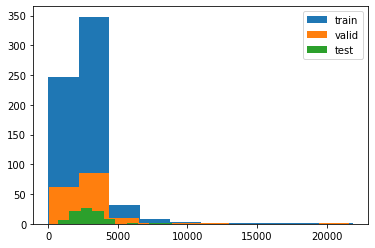

In [18]:
plt.hist(train1_y_early, label = 'train')
plt.hist(valid1_y_early, label = 'valid')
plt.hist(test1_pred, label = 'test')
plt.legend()

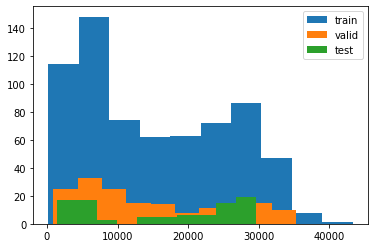

In [19]:
plt.hist(train2_y_early, label = 'train')
plt.hist(valid2_y_early, label = 'valid')
plt.hist(test2_pred, label = 'test')
plt.legend()

In [20]:
sub = pd.read_csv('sample_submission.csv')

In [21]:
sub['case_count'][sub['segment']==1] = test1_pred
sub['case_count'][sub['segment']==2] = test2_pred

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
sub.to_csv('gbr_cv_2models_1.csv',index = False)

In [23]:
sub1 = sub[['application_date','case_count']][sub['segment']==1]
sub1['application_date'] = pd.to_datetime(sub1['application_date'])
sub1 = sub1.set_index('application_date')

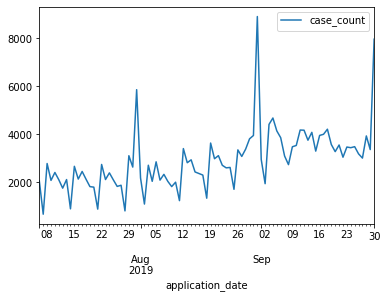

In [24]:
# plt.plot(sub1)
# plt.xticks(rotation=70)
sub1.plot()

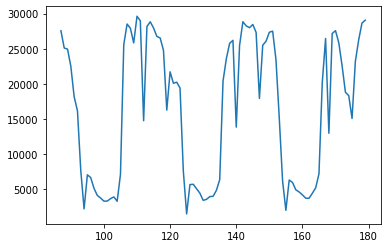

In [25]:
plt.plot(sub['case_count'][sub['segment']==2])

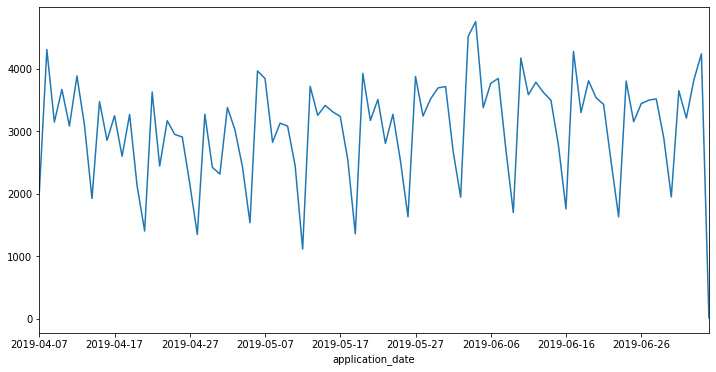

In [26]:
train1_y.index = train1_dates
plt.figure(figsize = (12,6))
train1_y[train1_y<6000][-90:].plot()

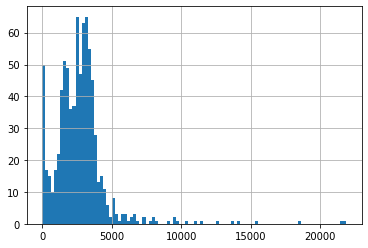

In [27]:
train1_y.hist(bins = 100)

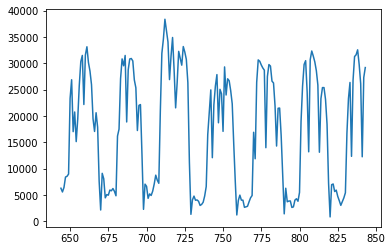

In [28]:
plt.plot(train2_y[-200:])

In [29]:
imp = best_est1.feature_importances_
features = train1_x_early.columns

importance_df = pd.DataFrame({'feature': features, 'importance': imp})

importance_df.sort_values(by = 'importance', ascending = False)

,feature,importance
6,application_Is_month_end,0.200562
12,application_Elapsed,0.196816
3,application_Day,0.186808
20,application_day_year_sin,0.103371
4,application_Dayofweek,0.049555
14,application_weekday_sin,0.043179
19,application_day_year_cos,0.041293
5,application_Dayofyear,0.034474
8,application_Is_quarter_end,0.025068
15,application_day_month_cos,0.024602


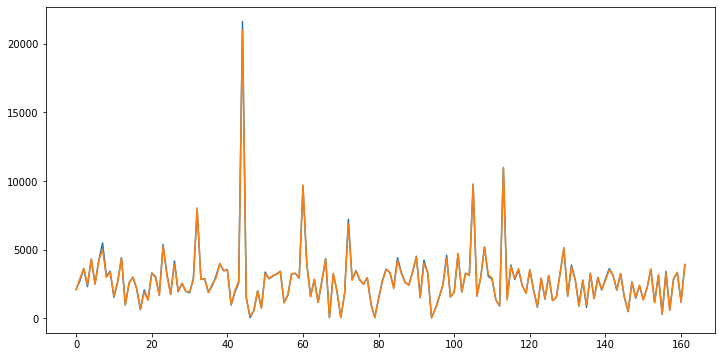

In [30]:
plt.figure(figsize = (12,6))
plt.plot(valid1_y_early.values)
plt.plot(train1_pred_valid)